## Load and preprocess data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical

In [2]:
train_data = pd.read_csv('/content/drive/MyDrive/cv_lab3_input/fashion-mnist_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/cv_lab3_input/fashion-mnist_test.csv')

In [3]:
train_X = np.array(train_data.iloc[:,1:])
test_X = np.array(test_data.iloc[:,1:])
train_Y = np.array (train_data.iloc[:,0])
test_Y = np.array(test_data.iloc[:,0])

In [4]:
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X] * 3)
train_X.shape, test_X.shape

((60000, 784, 3), (10000, 784, 3))

In [5]:
train_X = train_X.reshape(-1, 28, 28, 3)
test_X= test_X.reshape(-1, 28, 28, 3)
train_X.shape, test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [6]:
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in test_X])
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [7]:
train_X = train_X.astype('float32') / 255.
test_X = test_X.astype('float32') / 255.
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [8]:
train_X, valid_X, train_label, valid_label = train_test_split(
    train_X,
    train_Y_one_hot,
    test_size=0.2,
    random_state=13
)

In [9]:
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

## Create pretrained VGG16

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [11]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3

In [12]:
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input(test_X)

In [13]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [14]:
train_features = conv_base.predict(np.array(train_X), batch_size=64, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=64, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=64, verbose=1)

188/188 [==============================] - 8s 45ms/step


In [15]:
train_features.shape, test_features.shape, val_features.shape

((48000, 1, 1, 512), (10000, 1, 1, 512), (12000, 1, 1, 512))

In [16]:
train_features_flat = np.reshape(train_features, (48000, -1))
test_features_flat = np.reshape(test_features, (10000, -1))
val_features_flat = np.reshape(val_features, (12000, -1))

## Create classifier layers and train them

In [17]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers
from keras import callbacks

In [18]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(512)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [19]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

In [20]:
reduce_lr = callbacks.ReduceLROnPlateau(
    factor=0.2,
    patience=2,
    verbose=1,
    cooldown=2
)

In [21]:
history = model.fit(
    train_features_flat,
    train_label,
    epochs=50,
    validation_data=(val_features_flat, valid_label),
    callbacks=[reduce_lr]
)

Epoch 1/50
1500/1500 [==============================] - 8s 5ms/step - loss: 1.3985 - accuracy: 0.4730 - val_loss: 1.0838 - val_accuracy: 0.5910 - lr: 0.0010
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 1.0135 - accuracy: 0.6236 - val_loss: 0.9165 - val_accuracy: 0.6578 - lr: 0.0010
Epoch 3/50
1500/1500 [==============================] - 9s 6ms/step - loss: 0.9266 - accuracy: 0.6554 - val_loss: 0.9182 - val_accuracy: 0.6580 - lr: 0.0010
Epoch 4/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.8793 - accuracy: 0.6753 - val_loss: 0.8762 - val_accuracy: 0.6688 - lr: 0.0010
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.8419 - accuracy: 0.6901 - val_loss: 0.8049 - val_accuracy: 0.7069 - lr: 0.0010
Epoch 6/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.8275 - accuracy: 0.6932 - val_loss: 0.7939 - val_accuracy: 0.7077 - lr: 0.0010
Epoch 7/50
1500/1500 [==============================] - 7s

## Analysis

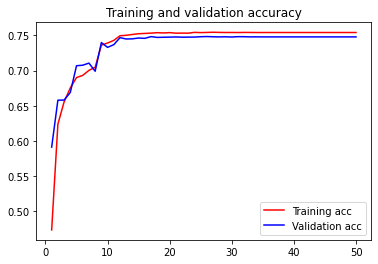

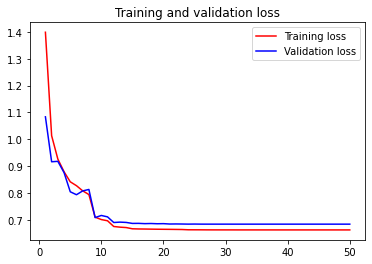

In [22]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuray = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, accuracy, 'red', label='Training acc')
plt.plot(epochs, val_accuray, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()